# Last test data : 2022-04-08

Files shared on Google Drive can be downloaded using *gdown* . gdown is not provided by default in Colab, so you can use *gdown* after installation.


In [1]:
!pip install --upgrade --no-cache-dir gdown

# UTKFace download from Auther's Google Drive
import gdown
google_path = 'https://drive.google.com/uc?id='
file_id = '16uEk67PncGCl0GxBRfa0iXfobODcs4tu'
output_name = '04_UTKFace.zip'
gdown.download(google_path+file_id,output_name,quiet=False)
# https://drive.google.com/file/d/16uEk67PncGCl0GxBRfa0iXfobODcs4tu/view?usp=sharing

# Unzip at Colab Root Directory 

!unzip /content/04_UTKFace.zip -d /content/

# Screen Cleaning, there are too many files to display.
from IPython.display import clear_output 
clear_output()

Let’s start by importing some libraries and creating our dictionary to help us on parsing the information from the dataset, along with some other information (dataset location, training split, width and height of the samples).

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR_TR = "/content/train"
DATA_DIR_TS = "/content/test"

IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

Let’s also define a function to help us on extracting the data from our dataset. This function will be used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the fields (age, gender and sex) of our records.

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

# create a pandas data frame of images, age, gender and race
files_TR = glob.glob(os.path.join(DATA_DIR_TR, "*.jpg"))
files_TS = glob.glob(os.path.join(DATA_DIR_TS, "*.jpg"))

files = files_TR + files_TS

attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,1,male,white,/content/train/1_0_0_20170110212658392.jpg
1,59,male,indian,/content/train/59_0_3_20170104212824964.jpg
2,24,female,asian,/content/train/24_1_2_20170116171627787.jpg
3,32,male,black,/content/train/32_0_1_20170117135943245.jpg
4,2,male,white,/content/train/2_0_0_20170103205800494.jpg


In [4]:
df.describe()

,age
count,24106.000000
mean,33.045175
std,20.139336
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


# Data visualization

데이터 세트의 분포를 확인합니다. 먼저 성별과 인종별로 데이터세트를 그룹화하고 차트를 표시해 보겠습니다.

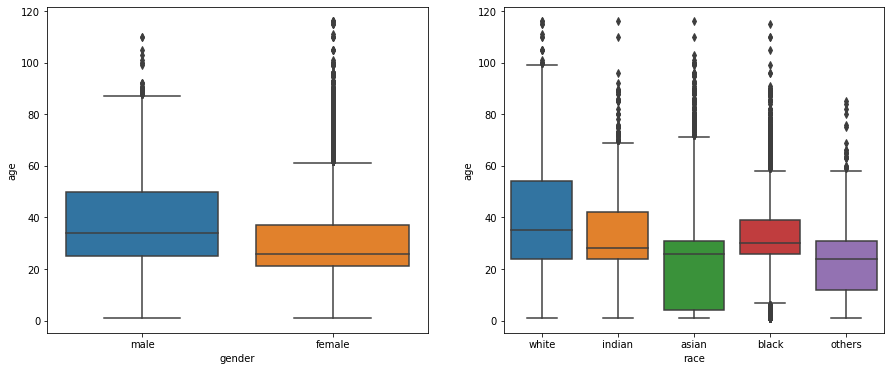

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

When grouped by race, we see that the age groups vary quite a lot. For even finer granularity, let’s plot a chart based on both gender and race.


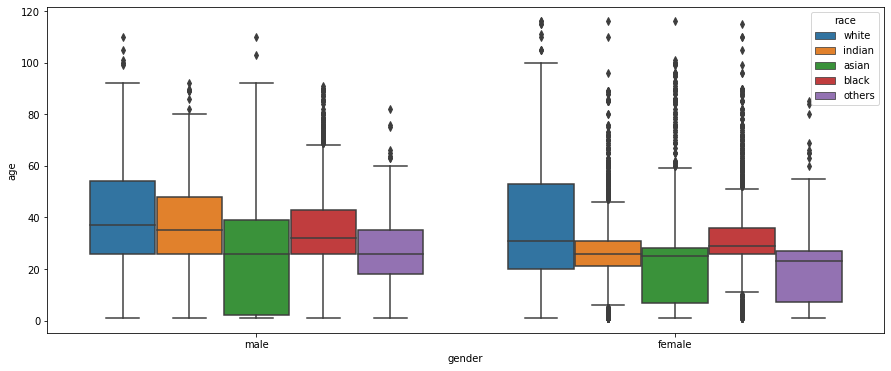

In [6]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

Since there is too much variation in distribution of data based on gender and rage. We’ll consider only a subset of data. After checking the histogram of age as shown below, we’ll only consider the data points that have age between 10 and 65.

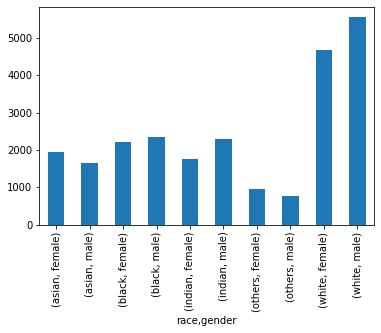

In [7]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

It turns out that there are many images of *white male* and *while female*. images from *others* category are very less in number compared to rest of the categories especially *white* category.
Let's analyze our data from *age* perspective.

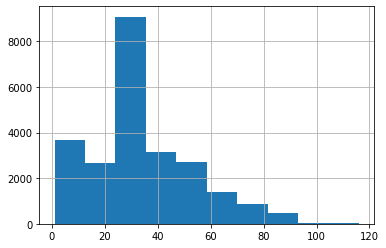

In [8]:
df['age'].hist()

In [9]:
df['age'].describe()

count    24106.000000
mean        33.045175
std         20.139336
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

## Data visualization

As an important step to understand not only the distribution of our dataset, but as well the predictions generated by our model, it is a recommended practice to perform some data visualization process on our dataset. We will start by defining a helper function to generate pie plots based on a given Pandas series:

In [10]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

## Race distribution

Let’s start by plotting the race distribution with our predefined plot_distribution method.

Having a quick glance at this plot, we can see that almost half of the samples are from the white race, so we can expect this group to have a great accuracy. Other races such as black, Indian and Asian also show a good number of samples, probably leading us to good accuracy numbers as well. The race ‘others’ (Hispanics, Latinos, etc) on the other side, show a small number of samples, being more likely to have a small accuracy.

In [11]:
plot_distribution(df['race'])

## Gender distribution

For both male and female samples, we have quite a good balanced number of records, so we should have a great accuracy for both classes when using our model.

In [12]:
plot_distribution(df['gender'])

## Age distribution

Let’s also plot how our age feature is distributed over the dataset by using a simple histogram with 20 bins/sectors.

In [13]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

We can also display this same plot in a pie plot. Let’s group the age column into bins and then plot it with a pie chart

In [14]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

# Data generator

In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model with both the images and their labels. This step is also done instead of just loading all the dataset into the memory at once, which could lead to an out of memory error.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from tensorflow.keras import Input, Model, Sequential

from tensorflow.keras.utils import to_categorical
import numpy as np

import os, random
import numpy as np
import cv2
# import PIL
from PIL import Image

import sys

IMG_SIZE = 64
train_size = 20856

X_train = []
Y_train_age = []
Y_train_gender = []
Y_train_race = []

count = 0
# for idx in range(train_size):
    # random_file = random.choice(os.listdir("./train")) #change dir name to whatever
for random_file in sorted(os.listdir("./train")):
    
    count += 1
    # print("%d} %s"%(idx+1,random_file))
    if count % 50 == 0:
        print("  %s"%(random_file))
    
    if (random_file.find('__') != -1):
        print("Filename has error!!")
        sys.exit()
    
    age, gender, race, _ = random_file.split('_')
    gender = int(gender)
    if gender > 1:
        print("Filename has error!!")
        sys.exit()
        
    image = cv2.imread("./train/"+random_file)
    img = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img = np.array(img)/255.
    age = float(age)/116.
    
    X_train.append(img)
    Y_train_age.append(age)
    Y_train_gender.append(gender)
    Y_train_race.append(race)
    
    
    # print(age, gender, race, np.max(img))
    # print(img.shape)
print(np.max(Y_train_gender))

X_train = np.array(X_train)
Y_train_age = np.array(Y_train_age)
Y_train_gender = np.array(Y_train_gender)
Y_train_gender = to_categorical(Y_train_gender, 2)    

Y_train_race = np.array(Y_train_race)
Y_train_race = to_categorical(Y_train_race, 5)    

print(X_train.shape)
print(Y_train_age.shape)
print(Y_train_gender.shape)
print(Y_train_race.shape)

X_test = []
Y_test_age = []
Y_test_gender = []
Y_test_race = []

count = 0
# for idx in range(test_size):
    # random_file = random.choice(os.listdir("./test")) #change dir name to whatever
for random_file in sorted(os.listdir("./test")):
    
    # print("%d} %s"%(idx+1,random_file))
    count += 1
    if count % 50 == 0:
        print("  %s"%(random_file))
    
    if (random_file.find('__') != -1):
        print("Filename has error!!")
        sys.exit()
    
    age, gender, race, _ = random_file.split('_')
    gender = int(gender)
    if gender > 1:
        print("Filename has error!!")
        sys.exit()
        
    image = cv2.imread("./test/"+random_file)
    img = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    img = np.array(img)/255.
    age = float(age)/116.
    
    X_test.append(img)
    Y_test_age.append(age)
    Y_test_gender.append(gender)
    Y_test_race.append(race)
    
    
    # print(age, gender, race, np.max(img))
    # print(img.shape)
print(np.max(Y_test_gender))

X_test = np.array(X_test)
Y_test_age = np.array(Y_test_age)
Y_test_gender = np.array(Y_test_gender)
Y_test_gender = to_categorical(Y_test_gender, 2)    

Y_test_race = np.array(Y_test_race)
Y_test_race = to_categorical(Y_test_race, 5)    

LABELS_RACE = [
    'white', 
    'black',
    'asian',
    'indian',
    'others'
]
    
LABELS_GENDER = [
    'male', 
    'female'
]

  10_0_0_20170110224255796.jpg
  10_0_4_20170103200335831.jpg
  10_1_1_20170109203520178.jpg
  11_0_0_20170110225459361.jpg
  12_0_0_20170110215739155.jpg
  12_1_0_20170104013410523.jpg
  12_1_2_20170103200649030.jpg
  13_0_0_20170110225307195.jpg
  13_1_4_20170103200733438.jpg
  14_0_1_20170113145153262.jpg
  14_1_0_20170109203505137.jpg
  14_1_2_20170109204853921.jpg
  15_0_0_20170110232443234.jpg
  15_1_0_20170103201844088.jpg
  15_1_1_20170112230550725.jpg
  16_0_0_20170110225715009.jpg
  16_0_0_20170110231944071.jpg
  16_0_1_20170105183511375.jpg
  16_1_0_20170109212525685.jpg
  16_1_1_20170114025520014.jpg
  17_0_0_20170110231748137.jpg
  17_0_4_20170103201116511.jpg
  17_1_1_20170113003736181.jpg
  18_0_0_20170110232106743.jpg
  18_0_3_20170117140743776.jpg
  18_1_0_20170109213137477.jpg
  18_1_0_20170109214610454.jpg
  18_1_2_20170105183417710.jpg
  19_0_0_20170116220704294.jpg
  19_1_0_20170116205908124.jpg
  1_0_0_20161219192713491.jpg
  1_0_0_20170109193328570.jpg
  1_0_0_20

# Building our model
In this step, we will define our multi-output Keras model. Our model will be composed of three major branches, one for each available feature: age, gender and race.

In [17]:
class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPool2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        # x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("softmax", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IMG_SIZE, IMG_SIZE, num_races=5)    

model.summary()


Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                           

Let’s give a look into our model structure, to have a better understanding of what we are building. We can see from it that we have a single input, that in our case is the image we are feeding the CNN, which does decompose into three separated branches, each with their own set of Convolutional layers, followed by their respective Dense layers.


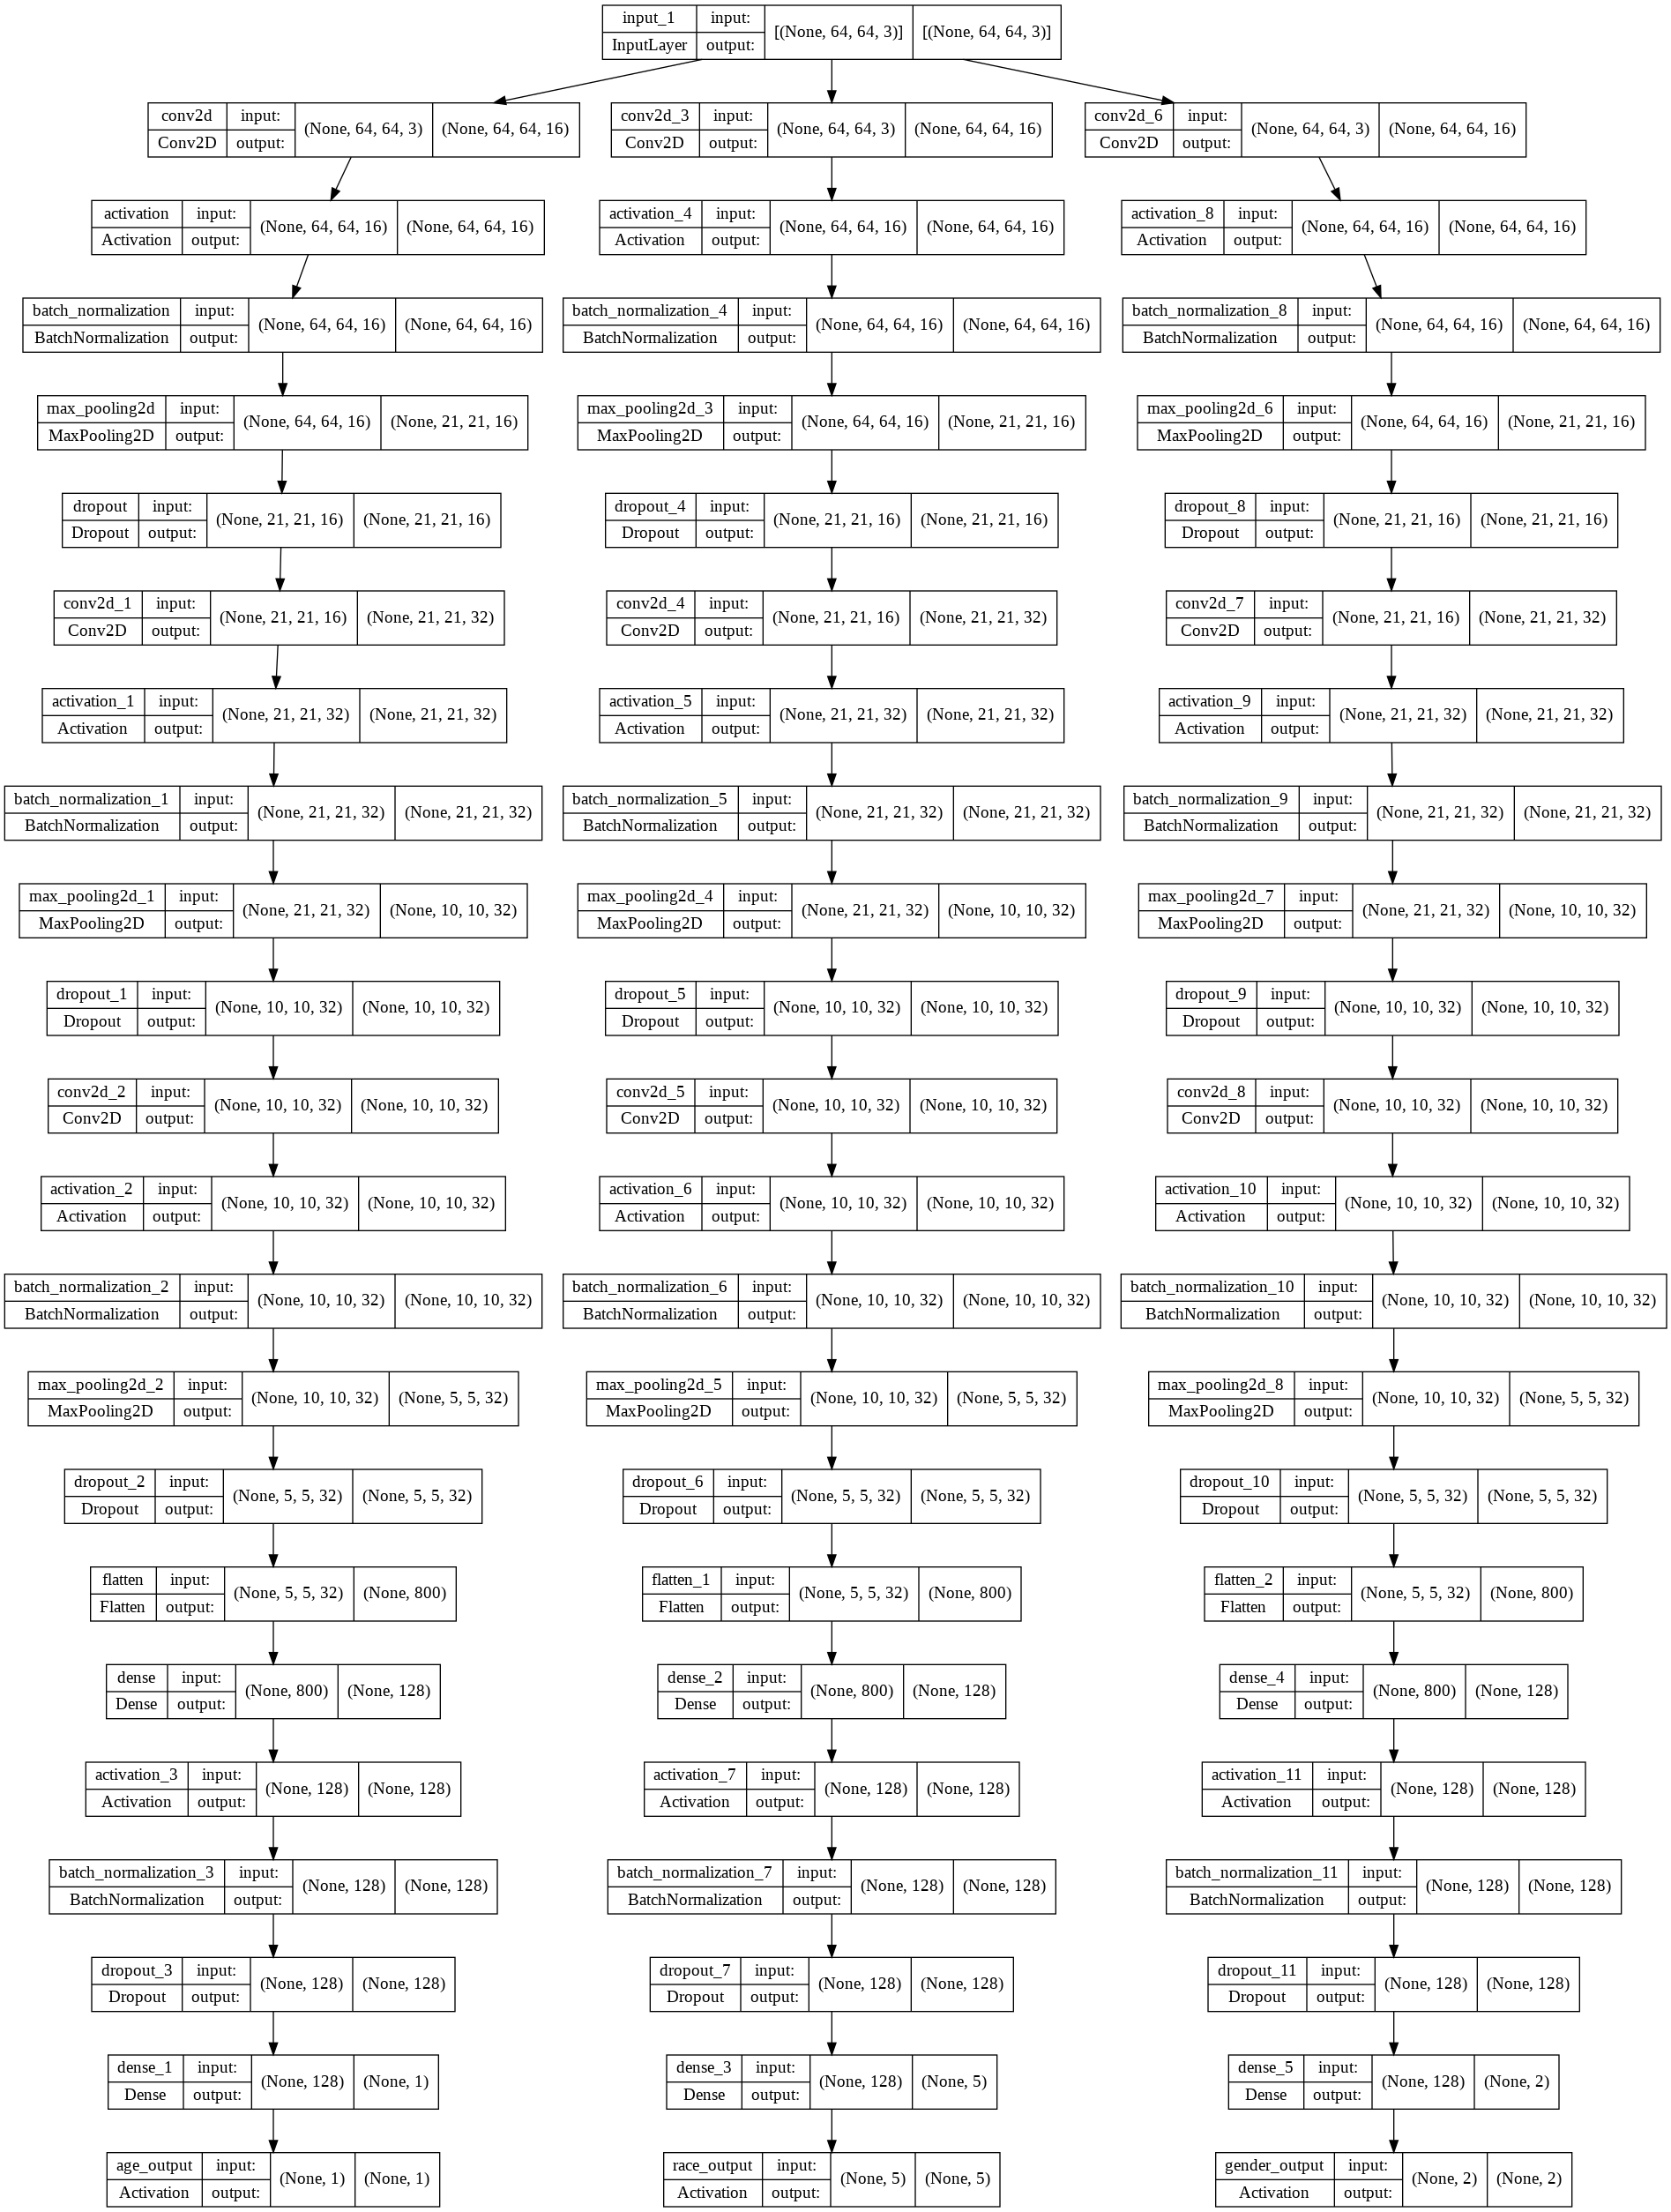

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

# Training our model
Now it’s time to train our multi-output model, once we have both the data ready to use and the model architecture defined. But before doing this step, we need to compile our model. For this task, we will use a learning rate of 0.0004 and an Adam optimizer — but you can be feel free to try with other hyperparameters as well. We will also use custom loss weights and a custom loss function for each feature. When building our optimizer, let’s use a decay based on the learning rate divided by the number of epochs, so we will slowly be decreasing our learning rate over the epochs.

In [19]:
# init_lr = 1e-4
epochs = 200

# opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer='adam', 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

# model.fit(X_train, [Y_train_age, Y_train_race, Y_train_gender], epochs=epochs, batch_size = 256)

"""
callbacks=callbacks, validation_data=valid_gen, validation_steps=len(valid_idx)//valid_batch_size)
X_train = []
Y_train_age = []
Y_train_gender = []
Y_train_race = []
"""

# model.evaluate(X_test,  [Y_test_age, Y_test_race, Y_test_gender], verbose=1)              



'\ncallbacks=callbacks, validation_data=valid_gen, validation_steps=len(valid_idx)//valid_batch_size)\nX_train = []\nY_train_age = []\nY_train_gender = []\nY_train_race = []\n'

In [20]:
history = model.fit(X_train, [Y_train_age, Y_train_race, Y_train_gender], epochs=epochs, batch_size = 256, validation_data = [X_test,  [Y_test_age, Y_test_race, Y_test_gender]])
# model.evaluate(X_test,  [Y_test_age, Y_test_race, Y_test_gender], verbose=1)              

Epoch 1/200
82/82 [==============================] - 16s 50ms/step - loss: 10.4331 - age_output_loss: 1.8351 - race_output_loss: 1.9971 - gender_output_loss: 0.9686 - age_output_mae: 1.0311 - race_output_accuracy: 0.3225 - gender_output_accuracy: 0.5606 - val_loss: 3.5225 - val_age_output_loss: 0.1368 - val_race_output_loss: 1.9411 - val_gender_output_loss: 0.6378 - val_age_output_mae: 0.3387 - val_race_output_accuracy: 0.2792 - val_gender_output_accuracy: 0.6950
Epoch 2/200
82/82 [==============================] - 3s 39ms/step - loss: 4.8277 - age_output_loss: 0.6100 - race_output_loss: 1.5440 - gender_output_loss: 0.7148 - age_output_mae: 0.5956 - race_output_accuracy: 0.4092 - gender_output_accuracy: 0.6232 - val_loss: 4.0912 - val_age_output_loss: 0.0792 - val_race_output_loss: 2.4769 - val_gender_output_loss: 0.5896 - val_age_output_mae: 0.2496 - val_race_output_accuracy: 0.2792 - val_gender_output_accuracy: 0.6943
Epoch 3/200
82/82 [==============================] - 3s 40ms/step 

# Race accuracy

In [21]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_accuracy'],
                    name='Train'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

# Gender accuracy

In [22]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_accuracy'],
                    name='Train'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

# Age Mean Absolute Error

In [23]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mae'],
                    name='Train'))
# fig.add_trace(go.Scattergl(
#                     y=history.history['val_age_output_mean_absolute_error'],
#                     name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

<Figure size 432x288 with 0 Axes>

# Overall loss

In [24]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
# fig.add_trace(go.Scattergl(
#                     y=history.history['val_loss'],
#                     name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [25]:
model.evaluate(X_test,  [Y_test_age, Y_test_race, Y_test_gender], verbose=1)

102/102 [==============================] - 1s 6ms/step - loss: 2.6751 - age_output_loss: 0.0144 - race_output_loss: 1.7249 - gender_output_loss: 0.3020 - age_output_mae: 0.0887 - race_output_accuracy: 0.4265 - gender_output_accuracy: 0.8742


[2.675107002258301,
 0.014395009726285934,
 1.7248857021331787,
 0.30199095606803894,
 0.08868999779224396,
 0.42650675773620605,
 0.874231219291687]